# 1. Install Dependencies and Setup

In [1]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.0
callbacks                    0.3.0
certifi                      2022.12.7
charset-normalizer           3.0.1
colorama                     0.4.6
comm                         0.1.2
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.6
decorator                    5.1.1
executing                    1.2.0
flatbuffers                  23.1.21
fonttools                    4.38.0
gast                         0.4.0
google-auth                  2.16.1
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.51.1
h5py                         3.8.0
idna                         3.4
ipykernel                    6.21.2
ipython                      8.10.0
jax 

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

C:\Users\jaswa\AppData\Local\Temp\ipykernel_2076\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

KeyboardInterrupt: 

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 41322 files belonging to 81 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

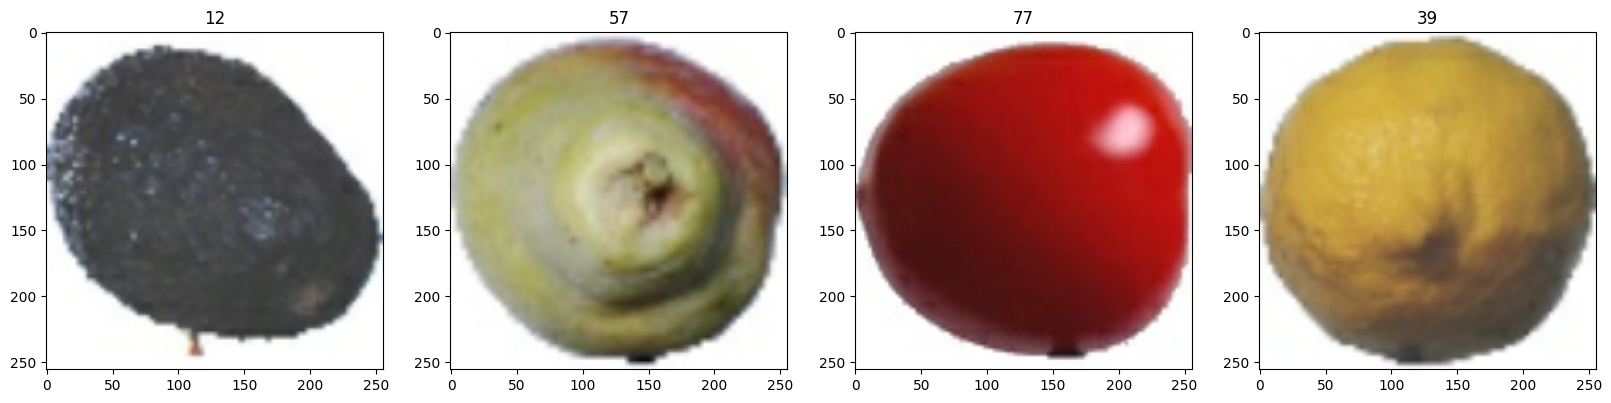

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size
val_size
test_size

129

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(128, 3, activation="relu", input_shape=(100,100,3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation="relu"))
model.add(Conv2D(32, 3, activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.50))
model.add(Flatten())
model.add(Dense(5000, activation = "relu"))
model.add(Dense(1000, activation = "relu"))
model.add(Dense(81, activation = "softmax"))
model.summary()

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=2, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/2
904/904 [==============================] - 453s 500ms/step - loss: -462.8377 - accuracy: 0.0120 - val_loss: -472.1025 - val_accuracy: 0.0110
Epoch 2/2
904/904 [==============================] - 450s 498ms/step - loss: -468.4813 - accuracy: 0.0119 - val_loss: -472.3045 - val_accuracy: 0.0110


# 8. Plot Performance

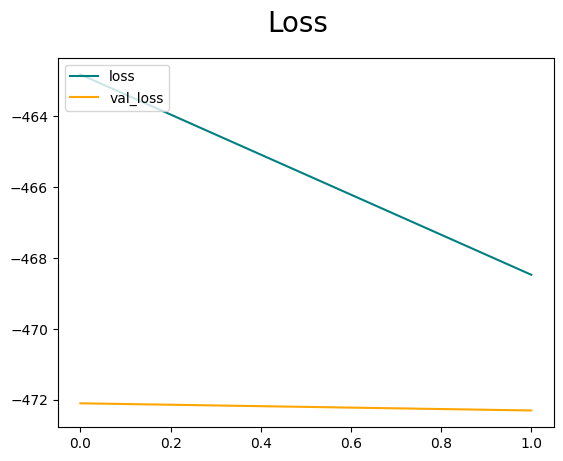

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

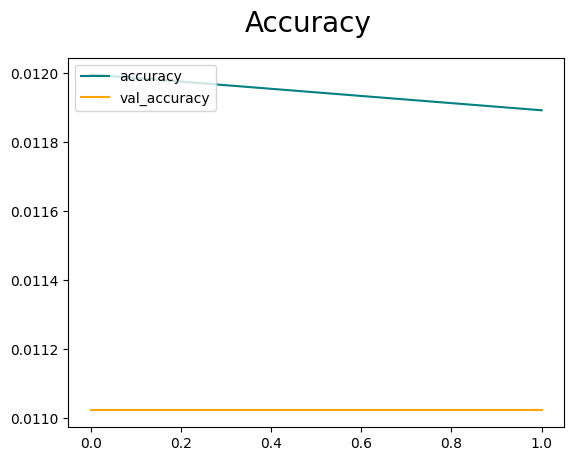

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# from keras.models import load_model

In [ ]:
# model = load_model(os.path.join('models','Fruitmodel1.h5'))

# 9. Evaluate

In [31]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

KeyboardInterrupt: 

In [ ]:
print(pre.result(), re.result(), acc.result())

# 10. Test

In [ ]:
import cv2

In [ ]:
img = cv2.imread('44_100.jpg')
# plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
# plt.imshow()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),resize.numpy().astype(int))

plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

# 11. Save the Model

In [ ]:
from keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))